# Introduction to DBnomics in Python

This tutorial explains how to obtain economic [time series](https://en.wikipedia.org/wiki/Time_series) from [DBnomics](https://db.nomics.world/), how to manipulate them and how to visualize them.

We will use well-known Python packages to achieve our goal, like [Pandas](http://pandas.pydata.org/) to represent tabular data, and [Altair](https://altair-viz.github.io/) to create the charts.

We will also use the [`dbnomics` Python package](https://git.nomics.world/dbnomics/dbnomics-python-client) to obtain data from the DBnomics Web API.

First, let's import those libraries:

In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
from altair import Chart, Scale, Y

from dbnomics import fetch_series, fetch_series_by_api_link

Note: in this notebook we are going to follow the conventions of the Scientific Python community. In particular, the `df` shortcut for `DataFrame`.

## Fetch one time series by its code

First, let's assume that we know which series we want to download. A series identifier (ID) is defined by three values, formatted like this: `provider_code/dataset_code/series_code`. We can use the `fetch_series` function, previously imported from the `dbnomics` Python package.

For example, to fetch the time series `EA19.1.0.0.0.ZUTN` from the ["Unemployment rate" [ZUTN] dataset](https://db.nomics.world/AMECO/ZUTN) belonging to the [AMECO provider](https://db.nomics.world/AMECO):

In [2]:
df1 = fetch_series('AMECO/ZUTN/EA19.1.0.0.0.ZUTN')

The returned data is stored in the `df1` variable. Its type is a [Pandas](http://pandas.pydata.org/) [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe).

Now let's display the first rows of this `DataFrame` by using the `head` method, each row representing an observation of the time series:

In [3]:
df1.head()

,@frequency,dataset_code,dataset_name,freq,geo,indexed_at,original_period,period,provider_code,series_code,series_name,unit,value
0,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1960,1960-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
1,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1961,1961-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
2,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1962,1962-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
3,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1963,1963-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
4,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1964,1964-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA


In such `DataFrame`, you will always find at least those columns:
- provider_code
- dataset_code
- dataset_name
- series_code
- series_name
- original_period (a `string`)
- period (a `datetime.date` of the first day of `original_period`)
- value
- @frequency (harmonized frequency generated by DBnomics)

The other columns depend on the provider and on the dataset. They always come in pairs (for the code and the name). In `df1`, you have:
- `unit` (code) and `Unit` (name) 
- `geo` (code) and `Country` (name)
- `freq` (code) and `Frequency` (name)

To plot the `DataFrame`, we need to remove the missing values (`NA`).

Note: DBnomics defines a unified `NA` value for missing values.

Let's define the following `clean_dataframe` helper function, using Pandas `query` method:

In [4]:
def clean_dataframe(df):
    return df.query("value != 'NA'")

Clean the previously downloaded `df1` `DataFrame`:

In [5]:
df1_clean = clean_dataframe(df1)
df1_clean.head()

,@frequency,dataset_code,dataset_name,freq,geo,indexed_at,original_period,period,provider_code,series_code,series_name,unit,value
38,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1998,1998-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,10.4
39,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1999,1999-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,9.7
40,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,2000,2000-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,8.9
41,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,2001,2001-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,8.3
42,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,2002,2002-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,8.6


Here we use the [Altair](https://altair-viz.github.io/) library to render charts, but you can use any other one like matplotlib, bqplot, plotly, etc.

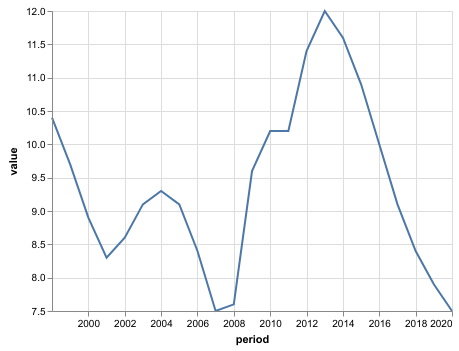

In [6]:
chart = Chart(df1_clean).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
)
chart

## Fetch two time series by their codes

Again, let's assume that we know which series we want to download. We can reuse the `fetch_series` function, this time with two series codes.

For example, to fetch the time series `EA19.1.0.0.0.ZUTN` and `DNK.1.0.0.0.ZUTN` from the ["Unemployment rate" [ZUTN] dataset](https://db.nomics.world/AMECO/ZUTN) belonging to the [AMECO provider](https://db.nomics.world/AMECO):

In [7]:
df2 = fetch_series([
    'AMECO/ZUTN/EA19.1.0.0.0.ZUTN',
    'AMECO/ZUTN/DNK.1.0.0.0.ZUTN',
])
df2.head()

,@frequency,dataset_code,dataset_name,freq,geo,indexed_at,original_period,period,provider_code,series_code,series_name,unit,value
0,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1960,1960-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
1,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1961,1961-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
2,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1962,1962-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
3,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1963,1963-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA
4,annual,ZUTN,Unemployment rate: total :- Member States: def...,a,ea19,2018-11-09T04:22:02.168Z,1964,1964-01-01,AMECO,EA19.1.0.0.0.ZUTN,Euro area,percentage-of-active-population,NA


In [8]:
df2_clean = clean_dataframe(df2).query("period >= '2000'")

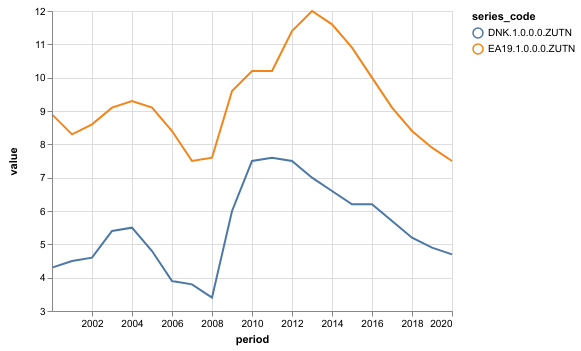

In [9]:
chart = Chart(df2_clean).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart

## Fetch series using a code mask

The code mask notation is a very concise way to select one or many time series at once. It is not compatible with all the providers (see [this list](https://git.nomics.world/dbnomics/dbnomics-api/blob/293603323b907ed3200580ab0ebe01ce60789972/dbnomics_api/application.cfg#L21)).

Quick description: given 3 dimensions "frequency", "country" and "indicator", you can select:
- one time series by giving its code: `"M.FR.PCPIEC_IX"`
- many series by enumerating dimensions codes: `"M.FR+DE.PCPIEC_IX"` is equivalent to `["M.FR.PCPIEC_IX", "M.DE.PCPIEC_IX"]`
- many series by skipping a dimension, repeating `"."` in the code mask: `"M..PCPIEC_IX"` is equivalent to `["M.country1.PCPIEC_IX", "M.country2.PCPIEC_IX", ..., "M.countryN.PCPIEC_IX"]`

In [10]:
code_mask_df = fetch_series("IMF", "CPI", series_code="M.FR+DE.PCPIEC_IX+PCPIA_IX")
code_mask_df = clean_dataframe(code_mask_df).query("period >= '2000' and period < '2002'")
code_mask_df.head()

,@frequency,FREQ,INDICATOR,REFERENCE_PERIOD,REF_AREA,dataset_code,dataset_name,indexed_at,original_period,period,provider_code,series_code,series_name,value
540,monthly,M,PCPIA_IX,2010A,DE,CPI,Consumer Price Index (CPI),2018-12-19T01:44:27.192Z,2000-01,2000-01-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.4
541,monthly,M,PCPIA_IX,2010A,DE,CPI,Consumer Price Index (CPI),2018-12-19T01:44:27.192Z,2000-02,2000-02-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.2
542,monthly,M,PCPIA_IX,2010A,DE,CPI,Consumer Price Index (CPI),2018-12-19T01:44:27.192Z,2000-03,2000-03-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.4
543,monthly,M,PCPIA_IX,2010A,DE,CPI,Consumer Price Index (CPI),2018-12-19T01:44:27.192Z,2000-04,2000-04-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.5
544,monthly,M,PCPIA_IX,2010A,DE,CPI,Consumer Price Index (CPI),2018-12-19T01:44:27.192Z,2000-05,2000-05-01,IMF,M.DE.PCPIA_IX,Monthly – Germany – Clothing and footwear,98.4


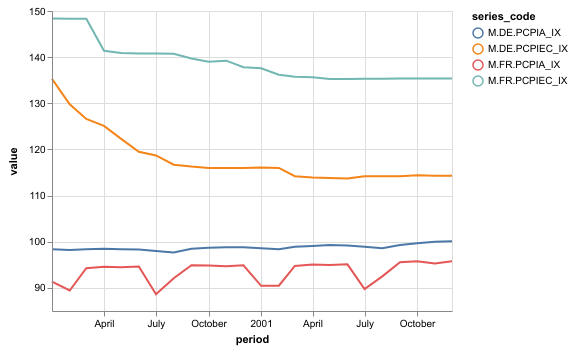

In [11]:
chart = Chart(code_mask_df).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart

## Fetch time series by their dimensions

Searching by dimension is a less concise way to select time series than using the code mask, but it's universal: some fetchers are not compatible with the code mask notation.

The following example fetches many series from the ["Doing Business" [DB]](https://db.nomics.world/WB/DB) dataset of the [World Bank](https://db.nomics.world/WB) provider, selecting for time series about France, Italy and Spain (`country` dimension), and the indicator "Procedures required to start a business - Women (number)" (`indicator` dimension):

In [12]:
df3 = fetch_series("WB", "DB", dimensions={
    "country": ["FR", "IT", "ES"],
    "indicator": ["IC.REG.COST.PC.FE.ZS.DRFN"],
})
df3.head()

,@frequency,ATTRIBUTE,country,dataset_code,dataset_name,indexed_at,indicator,original_period,period,provider_code,series_code,series_name,value
0,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2004,2004-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,91.60
1,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2005,2005-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,91.52
2,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2006,2006-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,91.76
3,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2007,2007-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,91.89
4,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2008,2008-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,92.47


To know the codes of the time series you got:

In [13]:
df3.series_code.unique().tolist()

['IC.REG.COST.PC.FE.ZS.DRFN-ES',
 'IC.REG.COST.PC.FE.ZS.DRFN-FR',
 'IC.REG.COST.PC.FE.ZS.DRFN-IT']

In [14]:
df3_clean = clean_dataframe(df3)

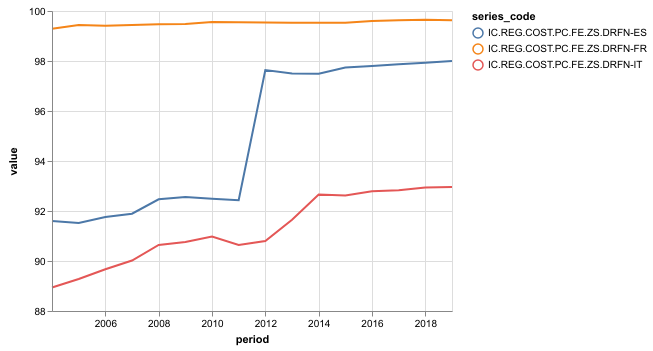

In [15]:
chart = Chart(df3_clean).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart

## Fetch time series found on the web site

When you don't know the codes of the dimensions, provider, dataset or series, you can:

- go to the page of a dataset on DBnomics website, for example [Doing Business](https://db.nomics.world/WB/DB),
- select some dimensions by using the input widgets of the left column,
- click on "Copy API link" in the menu of the "Download" button,
- use the `fetch_series_by_api_link` function such as below.

In [16]:
df4 = fetch_series_by_api_link("https://api.db.nomics.world/v22/series/WB/DB?observations=1&dimensions=%7B%22country%22%3A%5B%22FR%22%2C%22IT%22%2C%22ES%22%5D%2C%22indicator%22%3A%5B%22IC.REG.COST.PC.FE.ZS.DRFN%22%5D%7D")
df4.head()

,@frequency,ATTRIBUTE,country,dataset_code,dataset_name,indexed_at,indicator,original_period,period,provider_code,series_code,series_name,value
0,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2004,2004-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,91.60
1,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2005,2005-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,91.52
2,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2006,2006-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,91.76
3,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2007,2007-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,91.89
4,annual,,ES,DB,Doing Business,2018-12-10T04:14:34.078Z,IC.REG.COST.PC.FE.ZS.DRFN,2008,2008-01-01,WB,IC.REG.COST.PC.FE.ZS.DRFN-ES,Starting a business: Cost - Women (% of income...,92.47


In [17]:
df4_clean = clean_dataframe(df4)

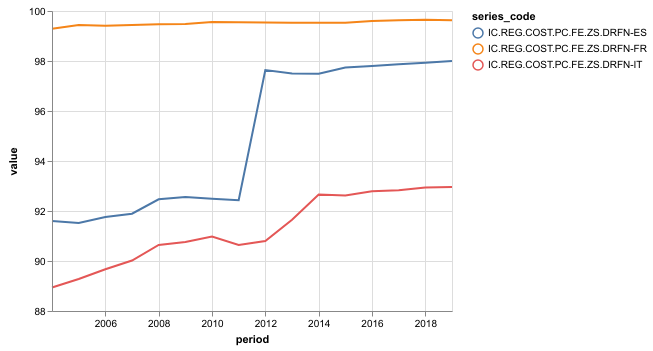

In [18]:
chart = Chart(df4_clean).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart

The chart is exactly the same than the previous one.

## Fetch time series from the cart

On the [cart page](https://db.nomics.world/cart) of the DBnomics website, click on "Copy API link" and copy-paste it as an argument of the `fetch_series_by_api_link` function.

Please note that when you update your cart, you have to copy this link again, because the link itself contains the IDs of the series in the cart.

In [19]:
cart_df = fetch_series_by_api_link("https://api.db.nomics.world/v22/series?series_ids=BOE%2F8745%2FLPMB23A%2CBOE%2F8745%2FLPMB26A&observations=1")
cart_df.head()

,@frequency,dataset_code,dataset_name,freq,indexed_at,original_period,period,provider_code,series_code,series_name,value
0,monthly,8745,Monthly lending secured on dwellings: approvals,M,2018-11-30T07:53:10.310Z,1999-01,1999-01-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,946.0
1,monthly,8745,Monthly lending secured on dwellings: approvals,M,2018-11-30T07:53:10.310Z,1999-02,1999-02-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,1570.0
2,monthly,8745,Monthly lending secured on dwellings: approvals,M,2018-11-30T07:53:10.310Z,1999-03,1999-03-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,2093.0
3,monthly,8745,Monthly lending secured on dwellings: approvals,M,2018-11-30T07:53:10.310Z,1999-04,1999-04-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,1850.0
4,monthly,8745,Monthly lending secured on dwellings: approvals,M,2018-11-30T07:53:10.310Z,1999-05,1999-05-01,BOE,LPMB23A,Monthly number of other specialist lenders' st...,1874.0


## Mix different frequencies on the same chart

In [20]:
multi_freq_df = clean_dataframe(fetch_series([
    "BEA/NIUnderlyingDetail-U001BC/S315-A",
    "BEA/NIUnderlyingDetail-U001BC/S315-Q",
    "BEA/NIUnderlyingDetail-U001BC/S315-M",
]))

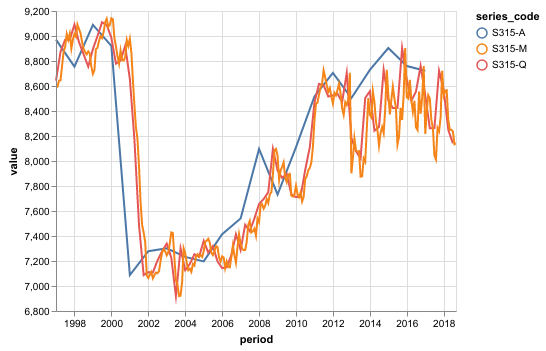

In [21]:
chart = Chart(multi_freq_df).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='series_code',
)
chart